In [20]:
print("Hello World!")

Hello World!


In [21]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping


d:\1\alpha\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 24, 128)        │        50,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,665 (350.25 KB)

 Trainable params: 89,665 (350.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 143s 77ms/step - loss: 0.0074 - val_loss: 0.0066
Epoch 2/10
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 132s 80ms/step - loss: 8.2106e-04 - val_loss: 0.0080
Epoch 3/10
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 137s 77ms/step - loss: 5.0407e-04 - val_loss: 0.0055
Epoch 4/10
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 150s 82ms/step - loss: 3.9039e-04 - val_loss: 0.0062
Epoch 5/10
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 184s 112ms/step - loss: 3.4084e-04 - val_loss: 0.0068
Epoch 6/10
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 209s 116ms/step - loss: 3.1442e-04 - val_loss: 0.0073
Epoch 7/10
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 154s 86ms/step - loss: 2.8636e-04 - val_loss: 0.0071
Epoch 8/10
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 124s 75ms/step - loss: 2.7126e-04 - val_loss: 0.0072
Epoch 9/10
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 187s 103ms/step - loss: 2.5616e-04 - val_loss: 0.0063
Epoch 10/10
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 184s 91ms/step - loss: 2.3462e-04 - val_loss: 0.0055
547/547 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step
MAE: 80

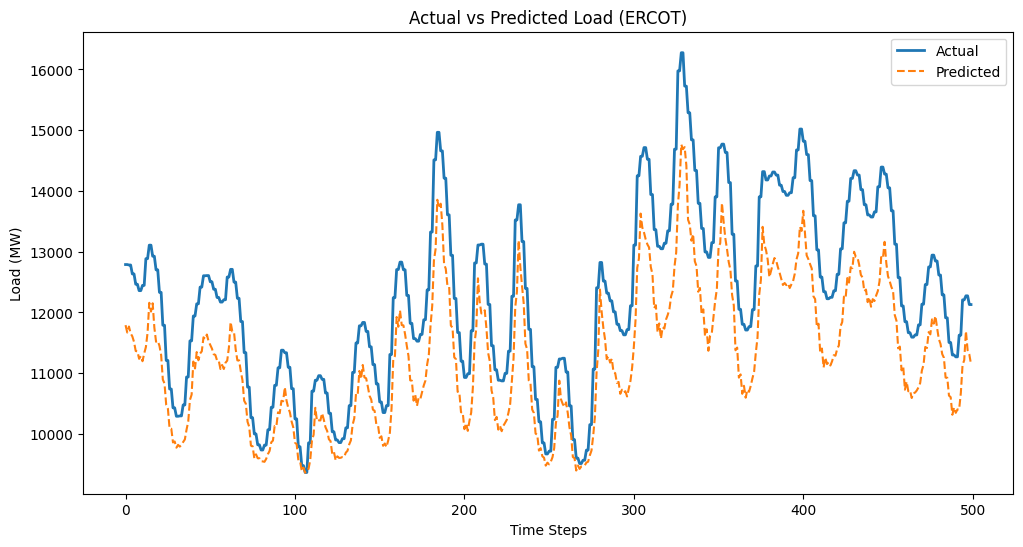

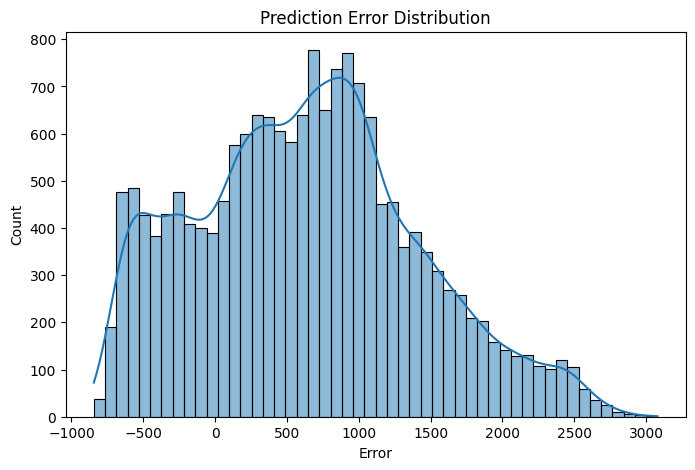

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load Data
ercot_data = pd.read_excel('D:/1/Load/DataSet/LoadTexasERCOT.xlsx')
weather_data1 = pd.read_excel('D:/1/Load/DataSet/WeatherStation1.xlsx')
weather_data2 = pd.read_excel('D:/1/Load/DataSet/WeatherStation2.xlsx')
weather_data3 = pd.read_excel('D:/1/Load/DataSet/WeatherStation3.xlsx')

# Convert timestamps
ercot_data['Hour_End'] = pd.to_datetime(ercot_data['Hour_End'])
ercot_data.set_index('Hour_End', inplace=True)

def process_weather_data(df):
    df['Datetime'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour', 'Minute']])
    df.set_index('Datetime', inplace=True)
    return df.drop(columns=['Year', 'Month', 'Day', 'Hour', 'Minute'])

weather_data1 = process_weather_data(weather_data1)
weather_data2 = process_weather_data(weather_data2)
weather_data3 = process_weather_data(weather_data3)

# Merge data
merged_data = ercot_data.copy()
for weather_data in [weather_data1, weather_data2, weather_data3]:
    merged_data = merged_data.merge(weather_data, left_index=True, right_index=True, how='outer')

# Fill missing values
merged_data = merged_data.ffill().bfill()

# Ensure target column exists
if 'ERCOT' not in merged_data.columns:
    raise ValueError("The target column 'ERCOT' is missing from the dataset.")

# Feature Scaling
scaler = MinMaxScaler()
features = merged_data.drop(columns=['ERCOT'])
scaled_features = scaler.fit_transform(features)
scaled_data = pd.DataFrame(scaled_features, columns=features.columns, index=features.index)
scaled_data['ERCOT'] = MinMaxScaler().fit_transform(merged_data[['ERCOT']])

# Train-Test Split
train = scaled_data.loc['2012':'2014']
test = scaled_data.loc['2015']

def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(x), np.array(y)

seq_length = 24
x_train, y_train = create_sequences(train['ERCOT'].values, seq_length)
x_test, y_test = create_sequences(test['ERCOT'].values, seq_length)

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

# Model Definition
model = Sequential([
    GRU(128, activation='relu', return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.3),
    GRU(64, activation='relu', return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.summary()

history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test), verbose=1)

# Predictions
predictions_scaled = model.predict(x_test)

# Ensure proper feature alignment for inverse scaling
dummy_array = np.zeros((predictions_scaled.shape[0], features.shape[1]))
dummy_array[:, 0] = predictions_scaled.flatten()
predictions = scaler.inverse_transform(dummy_array)[:, 0]
y_test_actual = scaler.inverse_transform(np.concatenate([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], features.shape[1]-1))], axis=1))[:, 0]

# Metrics
mae = mean_absolute_error(y_test_actual, predictions)
rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
mape = np.mean(np.abs((y_test_actual - predictions) / y_test_actual)) * 100
r2 = r2_score(y_test_actual, predictions)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")
print(f"R² Score: {r2}")

# Visualizations
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual[:500], label='Actual', linewidth=2)
plt.plot(predictions[:500], label='Predicted', linestyle='dashed')
plt.legend()
plt.title('Actual vs Predicted Load (ERCOT)')
plt.xlabel('Time Steps')
plt.ylabel('Load (MW)')
plt.show()

# Histogram
plt.figure(figsize=(8, 5))
sns.histplot(y_test_actual - predictions, bins=50, kde=True)
plt.title('Prediction Error Distribution')
plt.xlabel('Error')
plt.ylabel('Count')
plt.show()


d:\1\alpha\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
822/822 ━━━━━━━━━━━━━━━━━━━━ 290s 317ms/step - loss: 0.0194 - val_loss: 0.0095 - learning_rate: 5.0000e-04
Epoch 2/10
822/822 ━━━━━━━━━━━━━━━━━━━━ 239s 289ms/step - loss: 0.0046 - val_loss: 0.0079 - learning_rate: 5.0000e-04
Epoch 3/10
822/822 ━━━━━━━━━━━━━━━━━━━━ 262s 288ms/step - loss: 0.0037 - val_loss: 0.0092 - learning_rate: 5.0000e-04
Epoch 4/10
822/822 ━━━━━━━━━━━━━━━━━━━━ 297s 329ms/step - loss: 0.0032 - val_loss: 0.0104 - learning_rate: 5.0000e-04
Epoch 5/10
822/822 ━━━━━━━━━━━━━━━━━━━━ 302s 304ms/step - loss: 0.0031 - val_loss: 0.0088 - learning_rate: 5.0000e-04
Epoch 6/10
822/822 ━━━━━━━━━━━━━━━━━━━━ 260s 301ms/step - loss: 0.0029 - val_loss: 0.0078 - learning_rate: 5.0000e-04
Epoch 7/10
822/822 ━━━━━━━━━━━━━━━━━━━━ 295s 340ms/step - loss: 0.0028 - val_loss: 0.0095 - learning_rate: 5.0000e-04
Epoch 8/10
822/822 ━━━━━━━━━━━━━━━━━━━━ 308s 374ms/step - loss: 0.0027 - val_loss: 0.0086 - learning_rate: 2.5000e-04
Epoch 9/10
822/822 ━━━━━━━━━━━━━━━━━━━━ 248s 282ms/step 

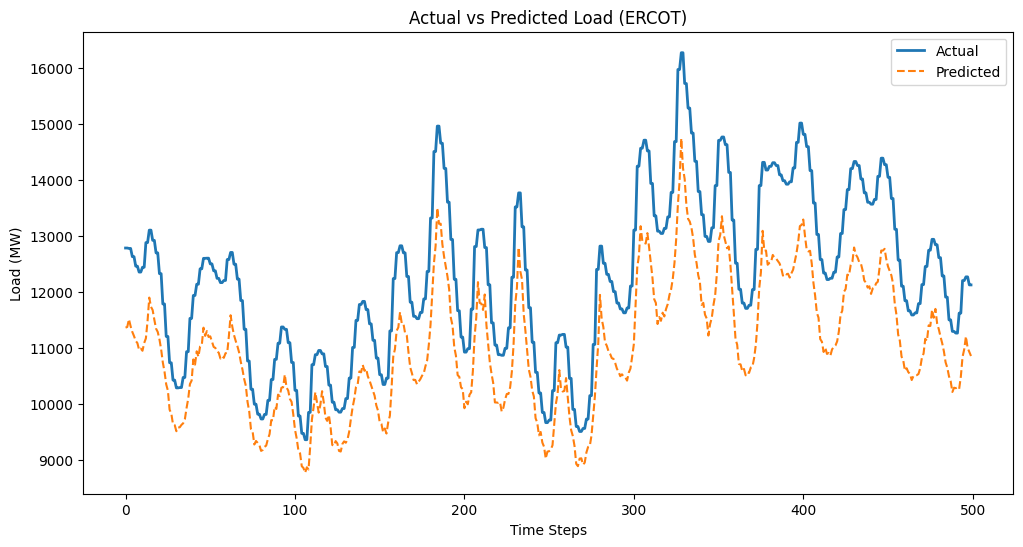

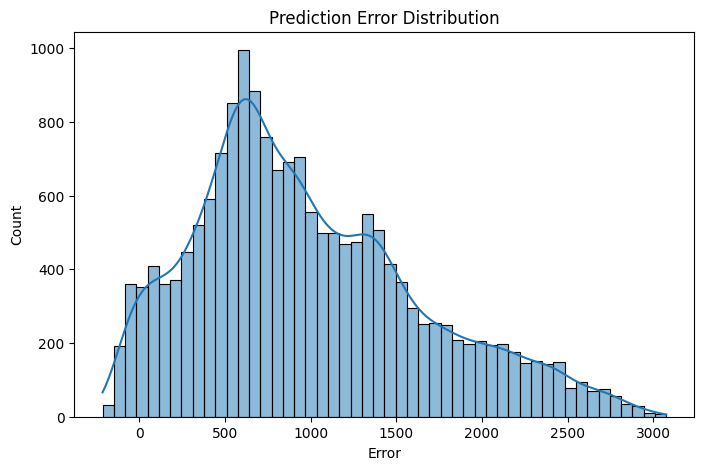

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load Data
ercot_data = pd.read_excel('D:/1/Load/DataSet/LoadTexasERCOT.xlsx')
weather_data1 = pd.read_excel('D:/1/Load/DataSet/WeatherStation1.xlsx')
weather_data2 = pd.read_excel('D:/1/Load/DataSet/WeatherStation2.xlsx')
weather_data3 = pd.read_excel('D:/1/Load/DataSet/WeatherStation3.xlsx')

# Convert timestamps
ercot_data['Hour_End'] = pd.to_datetime(ercot_data['Hour_End'])
ercot_data.set_index('Hour_End', inplace=True)

def process_weather_data(df):
    df['Datetime'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour', 'Minute']])
    df.set_index('Datetime', inplace=True)
    return df.drop(columns=['Year', 'Month', 'Day', 'Hour', 'Minute'])

weather_data1 = process_weather_data(weather_data1)
weather_data2 = process_weather_data(weather_data2)
weather_data3 = process_weather_data(weather_data3)

# Merge data
merged_data = ercot_data.copy()
for weather_data in [weather_data1, weather_data2, weather_data3]:
    merged_data = merged_data.merge(weather_data, left_index=True, right_index=True, how='outer')

# Fill missing values
merged_data = merged_data.ffill().bfill()

# Ensure target column exists
if 'ERCOT' not in merged_data.columns:
    raise ValueError("The target column 'ERCOT' is missing from the dataset.")

# Feature Scaling
scaler = MinMaxScaler()
features = merged_data.drop(columns=['ERCOT'])
scaled_features = scaler.fit_transform(features)
scaled_data = pd.DataFrame(scaled_features, columns=features.columns, index=features.index)
scaled_data['ERCOT'] = MinMaxScaler().fit_transform(merged_data[['ERCOT']])

# Train-Test Split
train = scaled_data.loc['2012':'2014']
test = scaled_data.loc['2015']

def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(x), np.array(y)

seq_length = 24
x_train, y_train = create_sequences(train['ERCOT'].values, seq_length)
x_test, y_test = create_sequences(test['ERCOT'].values, seq_length)

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

# Model Definition
model = Sequential([
    Bidirectional(GRU(128, return_sequences=True, activation='relu', dropout=0.2), input_shape=(seq_length, 1)),
    Bidirectional(GRU(64, return_sequences=True, activation='relu', dropout=0.2)),
    GRU(32, return_sequences=False, activation='relu', dropout=0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

# Callbacks for Adaptive Learning Rate and Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

# Train Model
history = model.fit(
    x_train, y_train, 
    epochs=10, 
    batch_size=64, 
    validation_data=(x_test, y_test), 
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

# Predictions
predictions_scaled = model.predict(x_test)

# Ensure proper feature alignment for inverse scaling
dummy_array = np.zeros((predictions_scaled.shape[0], features.shape[1]))
dummy_array[:, 0] = predictions_scaled.flatten()
predictions = scaler.inverse_transform(dummy_array)[:, 0]
y_test_actual = scaler.inverse_transform(np.concatenate([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], features.shape[1]-1))], axis=1))[:, 0]

# Metrics
mae = mean_absolute_error(y_test_actual, predictions)
rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
mape = np.mean(np.abs((y_test_actual - predictions) / y_test_actual)) * 100
r2 = r2_score(y_test_actual, predictions)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")
print(f"R² Score: {r2}")

# Visualizations
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual[:500], label='Actual', linewidth=2)
plt.plot(predictions[:500], label='Predicted', linestyle='dashed')
plt.legend()
plt.title('Actual vs Predicted Load (ERCOT)')
plt.xlabel('Time Steps')
plt.ylabel('Load (MW)')
plt.show()

# Histogram
plt.figure(figsize=(8, 5))
sns.histplot(y_test_actual - predictions, bins=50, kde=True)
plt.title('Prediction Error Distribution')
plt.xlabel('Error')
plt.ylabel('Count')
plt.show()


d:\1\alpha\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: LearningRateScheduler setting learning rate to 0.0005000000237487257.
Epoch 1/2
822/822 ━━━━━━━━━━━━━━━━━━━━ 290s 315ms/step - loss: 0.0284 - val_loss: 0.0173 - learning_rate: 5.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0005000000237487257.
Epoch 2/2
822/822 ━━━━━━━━━━━━━━━━━━━━ 251s 305ms/step - loss: 0.0083 - val_loss: 0.0166 - learning_rate: 5.0000e-04
547/547 ━━━━━━━━━━━━━━━━━━━━ 30s 50ms/step
MAE: 1422.3773865558037
RMSE: 1738.1652668493748
MAPE: 11.296719746549494%
R² Score: 0.5591360461675217


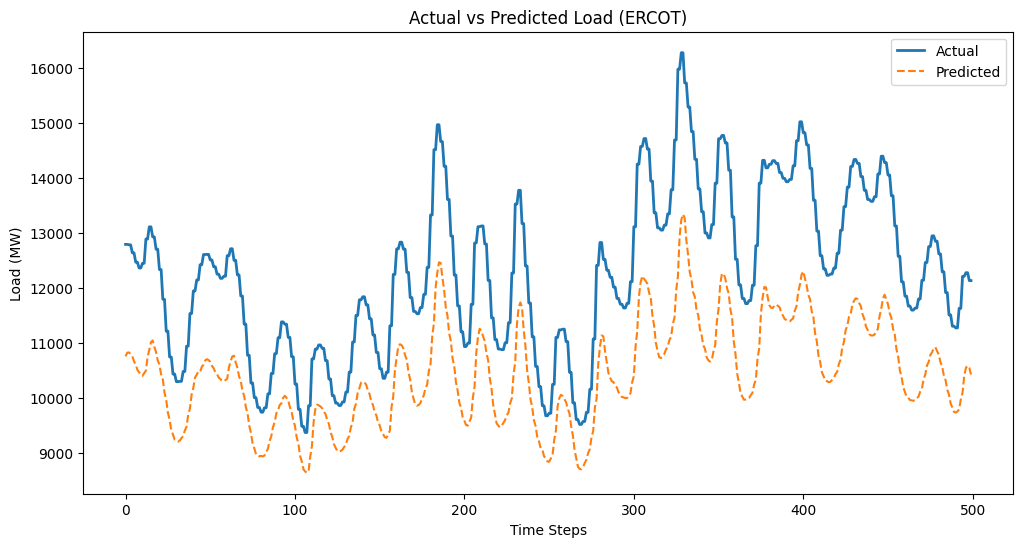

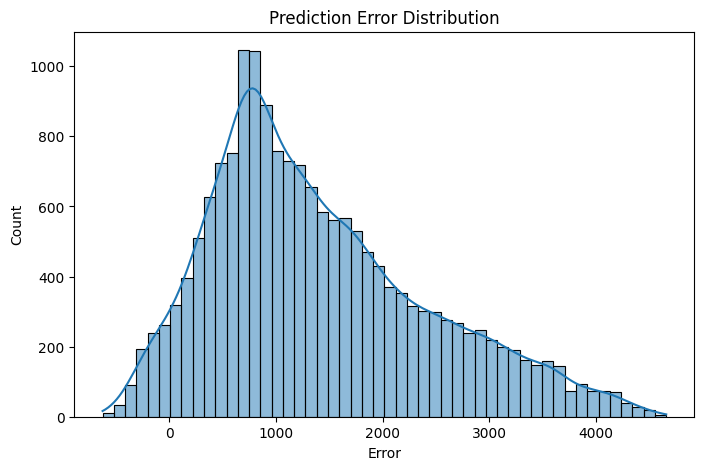

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

# Load Data
ercot_data = pd.read_excel('D:/1/Load/DataSet/LoadTexasERCOT.xlsx')
weather_data1 = pd.read_excel('D:/1/Load/DataSet/WeatherStation1.xlsx')
weather_data2 = pd.read_excel('D:/1/Load/DataSet/WeatherStation2.xlsx')
weather_data3 = pd.read_excel('D:/1/Load/DataSet/WeatherStation3.xlsx')

# Convert timestamps
ercot_data['Hour_End'] = pd.to_datetime(ercot_data['Hour_End'])
ercot_data.set_index('Hour_End', inplace=True)

def process_weather_data(df):
    df['Datetime'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour', 'Minute']])
    df.set_index('Datetime', inplace=True)
    return df.drop(columns=['Year', 'Month', 'Day', 'Hour', 'Minute'])

weather_data1 = process_weather_data(weather_data1)
weather_data2 = process_weather_data(weather_data2)
weather_data3 = process_weather_data(weather_data3)

# Merge data
merged_data = ercot_data.copy()
for weather_data in [weather_data1, weather_data2, weather_data3]:
    merged_data = merged_data.merge(weather_data, left_index=True, right_index=True, how='outer')

# Fill missing values
merged_data = merged_data.ffill().bfill()

# Ensure target column exists
if 'ERCOT' not in merged_data.columns:
    raise ValueError("The target column 'ERCOT' is missing from the dataset.")

# Feature Scaling
scaler = MinMaxScaler()
features = merged_data.drop(columns=['ERCOT'])
scaled_features = scaler.fit_transform(features)
scaled_data = pd.DataFrame(scaled_features, columns=features.columns, index=features.index)
scaled_data['ERCOT'] = MinMaxScaler().fit_transform(merged_data[['ERCOT']])

# Train-Test Split
train = scaled_data.loc['2012':'2014']
test = scaled_data.loc['2015']

def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(x), np.array(y)

seq_length = 24
x_train, y_train = create_sequences(train['ERCOT'].values, seq_length)
x_test, y_test = create_sequences(test['ERCOT'].values, seq_length)

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

# Model Definition
model = Sequential([
    Bidirectional(GRU(128, return_sequences=True, activation='relu', dropout=0.3), input_shape=(seq_length, 1)),
    Bidirectional(GRU(64, return_sequences=True, activation='relu', dropout=0.3)),
    GRU(32, return_sequences=False, activation='relu', dropout=0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1)
])

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

# Callbacks for Adaptive Learning Rate and Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

# Learning Rate Scheduler
def lr_scheduler(epoch, lr):
    if epoch > 5:
        return lr * 0.9
    return lr

lr_scheduler_callback = LearningRateScheduler(lr_scheduler, verbose=1)

# Train Model
history = model.fit(
    x_train, y_train, 
    epochs=2, 
    batch_size=64, 
    validation_data=(x_test, y_test), 
    verbose=1,
    callbacks=[early_stopping, reduce_lr, lr_scheduler_callback]
)

# Predictions
predictions_scaled = model.predict(x_test)

# Ensure proper feature alignment for inverse scaling
dummy_array = np.zeros((predictions_scaled.shape[0], features.shape[1]))
dummy_array[:, 0] = predictions_scaled.flatten()
predictions = scaler.inverse_transform(dummy_array)[:, 0]
y_test_actual = scaler.inverse_transform(np.concatenate([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], features.shape[1]-1))], axis=1))[:, 0]

# Metrics
mae = mean_absolute_error(y_test_actual, predictions)
rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
mape = np.mean(np.abs((y_test_actual - predictions) / y_test_actual)) * 100
r2 = r2_score(y_test_actual, predictions)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")
print(f"R² Score: {r2}")

# Visualizations
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual[:500], label='Actual', linewidth=2)
plt.plot(predictions[:500], label='Predicted', linestyle='dashed')
plt.legend()
plt.title('Actual vs Predicted Load (ERCOT)')
plt.xlabel('Time Steps')
plt.ylabel('Load (MW)')
plt.show()

# Histogram
plt.figure(figsize=(8, 5))
sns.histplot(y_test_actual - predictions, bins=50, kde=True)
plt.title('Prediction Error Distribution')
plt.xlabel('Error')
plt.ylabel('Count')
plt.show()


Epoch 1/2
822/822 ━━━━━━━━━━━━━━━━━━━━ 167s 187ms/step - loss: 0.0137 - val_loss: 5.8433e-04 - learning_rate: 5.0000e-04
Epoch 2/2
822/822 ━━━━━━━━━━━━━━━━━━━━ 204s 188ms/step - loss: 0.0023 - val_loss: 5.9643e-04 - learning_rate: 5.0000e-04
547/547 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step
MAE: 240.42863467092778
RMSE: 325.65094120493205
MAPE: 2.021221090162562%
R² Score: 0.9845251256268762


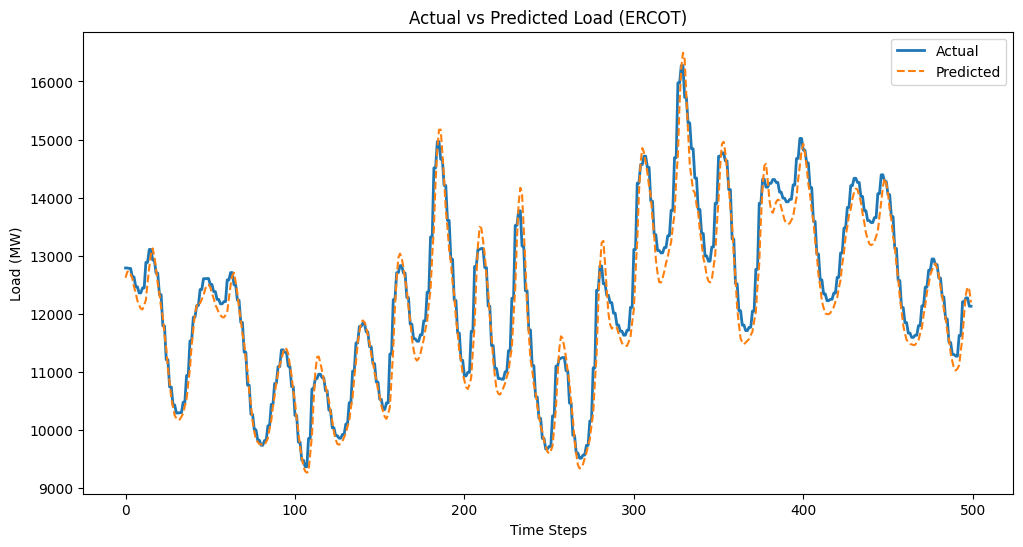

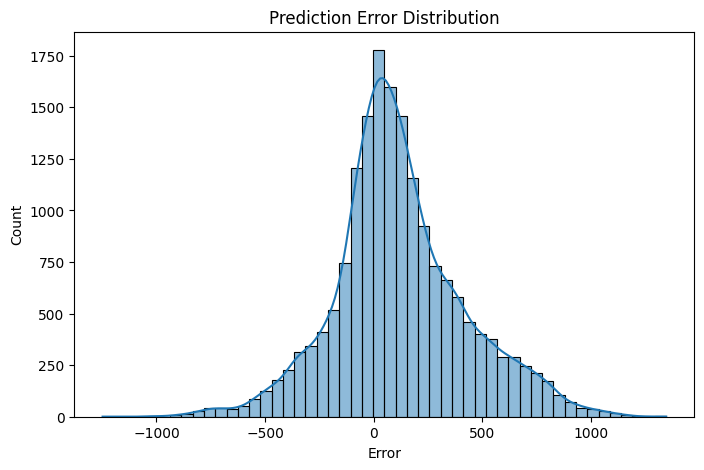

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Bidirectional, Attention, Concatenate, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load Data
ercot_data = pd.read_excel('D:/1/Load/DataSet/LoadTexasERCOT.xlsx')
weather_data1 = pd.read_excel('D:/1/Load/DataSet/WeatherStation1.xlsx')
weather_data2 = pd.read_excel('D:/1/Load/DataSet/WeatherStation2.xlsx')
weather_data3 = pd.read_excel('D:/1/Load/DataSet/WeatherStation3.xlsx')

# Convert timestamps
ercot_data['Hour_End'] = pd.to_datetime(ercot_data['Hour_End'])
ercot_data.set_index('Hour_End', inplace=True)

def process_weather_data(df):
    df['Datetime'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour', 'Minute']])
    df.set_index('Datetime', inplace=True)
    return df.drop(columns=['Year', 'Month', 'Day', 'Hour', 'Minute'])

weather_data1 = process_weather_data(weather_data1)
weather_data2 = process_weather_data(weather_data2)
weather_data3 = process_weather_data(weather_data3)

# Merge data
merged_data = ercot_data.copy()
for weather_data in [weather_data1, weather_data2, weather_data3]:
    merged_data = merged_data.merge(weather_data, left_index=True, right_index=True, how='outer')

# Fill missing values
merged_data = merged_data.ffill().bfill()

# Ensure target column exists
if 'ERCOT' not in merged_data.columns:
    raise ValueError("The target column 'ERCOT' is missing from the dataset.")

# Feature Scaling
scaler = MinMaxScaler()
features = merged_data.drop(columns=['ERCOT'])
scaled_features = scaler.fit_transform(features)
scaled_data = pd.DataFrame(scaled_features, columns=features.columns, index=features.index)
scaled_data['ERCOT'] = MinMaxScaler().fit_transform(merged_data[['ERCOT']])

# Train-Test Split
train = scaled_data.loc['2012':'2014']
test = scaled_data.loc['2015']

def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(x), np.array(y)

seq_length = 24
x_train, y_train = create_sequences(train['ERCOT'].values, seq_length)
x_test, y_test = create_sequences(test['ERCOT'].values, seq_length)

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

# Build a Better Model with Attention Mechanism
input_layer = Input(shape=(seq_length, 1))

# First GRU Layer
gru_1 = GRU(128, return_sequences=True)(input_layer)
dropout_1 = Dropout(0.2)(gru_1)

# Attention Mechanism
attention = Attention(use_scale=True)([dropout_1, dropout_1])
context_vector = Concatenate(axis=-1)([dropout_1, attention])

# Second GRU Layer
gru_2 = GRU(64, return_sequences=False)(context_vector)
dropout_2 = Dropout(0.2)(gru_2)

# Fully Connected Layer
dense_1 = Dense(32, activation='relu')(dropout_2)
dropout_3 = Dropout(0.2)(dense_1)

# Output Layer
output = Dense(1)(dropout_3)

# Compile Model
model = tf.keras.models.Model(inputs=input_layer, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

# Callbacks for Early Stopping and Learning Rate Reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

# Train Model
history = model.fit(
    x_train, y_train, 
    epochs=2, 
    batch_size=64, 
    validation_data=(x_test, y_test), 
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

# Predictions
predictions_scaled = model.predict(x_test)

# Inverse Scaling
dummy_array = np.zeros((predictions_scaled.shape[0], features.shape[1]))
dummy_array[:, 0] = predictions_scaled.flatten()
predictions = scaler.inverse_transform(dummy_array)[:, 0]
y_test_actual = scaler.inverse_transform(np.concatenate([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], features.shape[1]-1))], axis=1))[:, 0]

# Metrics
mae = mean_absolute_error(y_test_actual, predictions)
rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
mape = np.mean(np.abs((y_test_actual - predictions) / y_test_actual)) * 100
r2 = r2_score(y_test_actual, predictions)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")
print(f"R² Score: {r2}")

# Visualizations
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual[:500], label='Actual', linewidth=2)
plt.plot(predictions[:500], label='Predicted', linestyle='dashed')
plt.legend()
plt.title('Actual vs Predicted Load (ERCOT)')
plt.xlabel('Time Steps')
plt.ylabel('Load (MW)')
plt.show()

# Histogram of Errors
plt.figure(figsize=(8, 5))
sns.histplot(y_test_actual - predictions, bins=50, kde=True)
plt.title('Prediction Error Distribution')
plt.xlabel('Error')
plt.ylabel('Count')
plt.show()


Epoch 1/10
822/822 ━━━━━━━━━━━━━━━━━━━━ 239s 263ms/step - loss: 0.0117 - val_loss: 5.0972e-04 - learning_rate: 5.0000e-04
Epoch 2/10
822/822 ━━━━━━━━━━━━━━━━━━━━ 227s 219ms/step - loss: 0.0023 - val_loss: 3.5942e-04 - learning_rate: 5.0000e-04
Epoch 3/10
822/822 ━━━━━━━━━━━━━━━━━━━━ 140s 170ms/step - loss: 0.0016 - val_loss: 3.1316e-04 - learning_rate: 5.0000e-04
Epoch 4/10
822/822 ━━━━━━━━━━━━━━━━━━━━ 148s 180ms/step - loss: 0.0012 - val_loss: 3.0234e-04 - learning_rate: 5.0000e-04
Epoch 5/10
822/822 ━━━━━━━━━━━━━━━━━━━━ 223s 205ms/step - loss: 0.0010 - val_loss: 3.1641e-04 - learning_rate: 5.0000e-04
Epoch 6/10
822/822 ━━━━━━━━━━━━━━━━━━━━ 396s 477ms/step - loss: 9.8489e-04 - val_loss: 2.4503e-04 - learning_rate: 5.0000e-04
Epoch 7/10
822/822 ━━━━━━━━━━━━━━━━━━━━ 215s 198ms/step - loss: 9.3443e-04 - val_loss: 1.5729e-04 - learning_rate: 5.0000e-04
Epoch 8/10
822/822 ━━━━━━━━━━━━━━━━━━━━ 311s 330ms/step - loss: 9.6212e-04 - val_loss: 2.2183e-04 - learning_rate: 5.0000e-04
Epoch 9/10
8

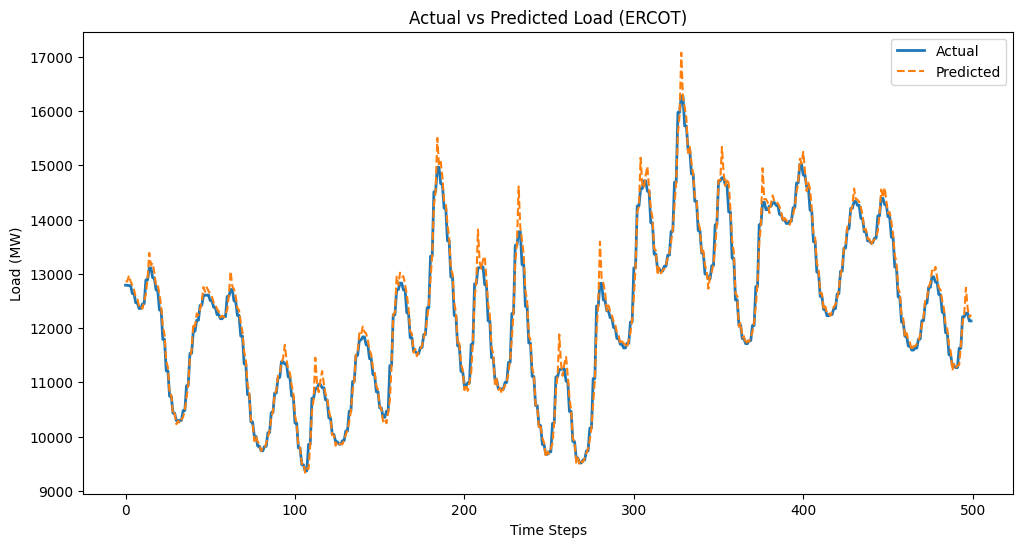

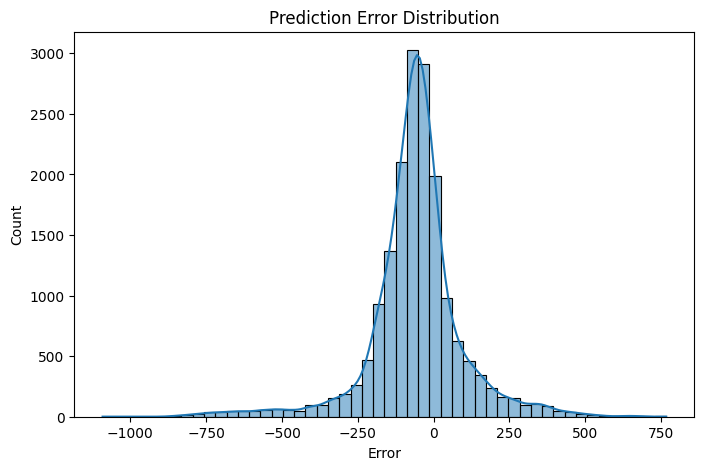

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Bidirectional, Attention, Concatenate, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load Data
ercot_data = pd.read_excel('D:/1/Load/DataSet/LoadTexasERCOT.xlsx')
weather_data1 = pd.read_excel('D:/1/Load/DataSet/WeatherStation1.xlsx')
weather_data2 = pd.read_excel('D:/1/Load/DataSet/WeatherStation2.xlsx')
weather_data3 = pd.read_excel('D:/1/Load/DataSet/WeatherStation3.xlsx')

# Convert timestamps
ercot_data['Hour_End'] = pd.to_datetime(ercot_data['Hour_End'])
ercot_data.set_index('Hour_End', inplace=True)

def process_weather_data(df):
    df['Datetime'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour', 'Minute']])
    df.set_index('Datetime', inplace=True)
    return df.drop(columns=['Year', 'Month', 'Day', 'Hour', 'Minute'])

weather_data1 = process_weather_data(weather_data1)
weather_data2 = process_weather_data(weather_data2)
weather_data3 = process_weather_data(weather_data3)

# Merge data
merged_data = ercot_data.copy()
for weather_data in [weather_data1, weather_data2, weather_data3]:
    merged_data = merged_data.merge(weather_data, left_index=True, right_index=True, how='outer')

# Fill missing values
merged_data = merged_data.ffill().bfill()

# Ensure target column exists
if 'ERCOT' not in merged_data.columns:
    raise ValueError("The target column 'ERCOT' is missing from the dataset.")

# Feature Scaling
scaler = MinMaxScaler()
features = merged_data.drop(columns=['ERCOT'])
scaled_features = scaler.fit_transform(features)
scaled_data = pd.DataFrame(scaled_features, columns=features.columns, index=features.index)
scaled_data['ERCOT'] = MinMaxScaler().fit_transform(merged_data[['ERCOT']])

# Train-Test Split
train = scaled_data.loc['2012':'2014']
test = scaled_data.loc['2015']

def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(x), np.array(y)

seq_length = 24
x_train, y_train = create_sequences(train['ERCOT'].values, seq_length)
x_test, y_test = create_sequences(test['ERCOT'].values, seq_length)

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

# Build a Better Model with Attention Mechanism
input_layer = Input(shape=(seq_length, 1))

# First GRU Layer
gru_1 = GRU(128, return_sequences=True)(input_layer)
dropout_1 = Dropout(0.2)(gru_1)

# Attention Mechanism
attention = Attention(use_scale=True)([dropout_1, dropout_1])
context_vector = Concatenate(axis=-1)([dropout_1, attention])

# Second GRU Layer
gru_2 = GRU(64, return_sequences=False)(context_vector)
dropout_2 = Dropout(0.2)(gru_2)

# Fully Connected Layer
dense_1 = Dense(32, activation='relu')(dropout_2)
dropout_3 = Dropout(0.2)(dense_1)

# Output Layer
output = Dense(1)(dropout_3)

# Compile Model
model = tf.keras.models.Model(inputs=input_layer, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

# Callbacks for Early Stopping and Learning Rate Reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

# Train Model
history = model.fit(
    x_train, y_train, 
    epochs=10, 
    batch_size=64, 
    validation_data=(x_test, y_test), 
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

# Predictions
predictions_scaled = model.predict(x_test)

# Inverse Scaling
dummy_array = np.zeros((predictions_scaled.shape[0], features.shape[1]))
dummy_array[:, 0] = predictions_scaled.flatten()
predictions = scaler.inverse_transform(dummy_array)[:, 0]
y_test_actual = scaler.inverse_transform(np.concatenate([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], features.shape[1]-1))], axis=1))[:, 0]

# Metrics
mae = mean_absolute_error(y_test_actual, predictions)
rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
mape = np.mean(np.abs((y_test_actual - predictions) / y_test_actual)) * 100
r2 = r2_score(y_test_actual, predictions)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")
print(f"R² Score: {r2}")

# Visualizations
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual[:500], label='Actual', linewidth=2)
plt.plot(predictions[:500], label='Predicted', linestyle='dashed')
plt.legend()
plt.title('Actual vs Predicted Load (ERCOT)')
plt.xlabel('Time Steps')
plt.ylabel('Load (MW)')
plt.show()

# Histogram of Errors
plt.figure(figsize=(8, 5))
sns.histplot(y_test_actual - predictions, bins=50, kde=True)
plt.title('Prediction Error Distribution')
plt.xlabel('Error')
plt.ylabel('Count')
plt.show()


In [26]:
from sklearn.metrics import explained_variance_score

# Explained Variance Score
evs = explained_variance_score(y_test_actual, predictions)
print(f"Explained Variance Score: {evs}")

# Adjusted R²
n = len(y_test_actual)  # Number of observations
p = x_test.shape[1]     # Number of features
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f"Adjusted R² Score: {adj_r2}")


Explained Variance Score: 0.9963305340774885
Adjusted R² Score: 0.9958286857779952


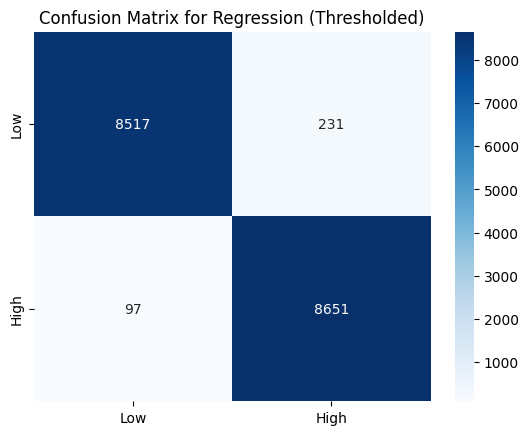

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      8748
           1       0.97      0.99      0.98      8748

    accuracy                           0.98     17496
   macro avg       0.98      0.98      0.98     17496
weighted avg       0.98      0.98      0.98     17496



In [27]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Convert regression predictions to binary classes (you can define thresholds based on your data)
threshold = np.percentile(y_test_actual, 50)  # Example threshold at median
y_test_class = (y_test_actual > threshold).astype(int)  # Convert actual values to 0 or 1

predictions_class = (predictions > threshold).astype(int)  # Convert predicted values to 0 or 1

# Confusion Matrix
cm = confusion_matrix(y_test_class, predictions_class)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.title('Confusion Matrix for Regression (Thresholded)')
plt.show()

# Classification Report
print(classification_report(y_test_class, predictions_class))


In [28]:
def accuracy_metric(y_true, y_pred, threshold=0.05):
    # Accuracy as percentage of predictions within a certain threshold
    accuracy = np.mean(np.abs(y_true - y_pred) / y_true <= threshold)
    return accuracy

# Calculate Accuracy for Test Set
test_accuracy = accuracy_metric(y_test_actual, predictions, threshold=0.05)
print(f"Test Set Accuracy (within 5%): {test_accuracy * 100:.2f}%")


Test Set Accuracy (within 5%): 98.43%


In [29]:
# Get validation set predictions
val_predictions_scaled = model.predict(x_test)  # Already defined earlier
val_predictions = scaler.inverse_transform(dummy_array)[:, 0]

# Calculate Accuracy for Validation Set
val_accuracy = accuracy_metric(y_test_actual, val_predictions, threshold=0.05)
print(f"Validation Set Accuracy (within 5%): {val_accuracy * 100:.2f}%")


547/547 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step
Validation Set Accuracy (within 5%): 98.43%


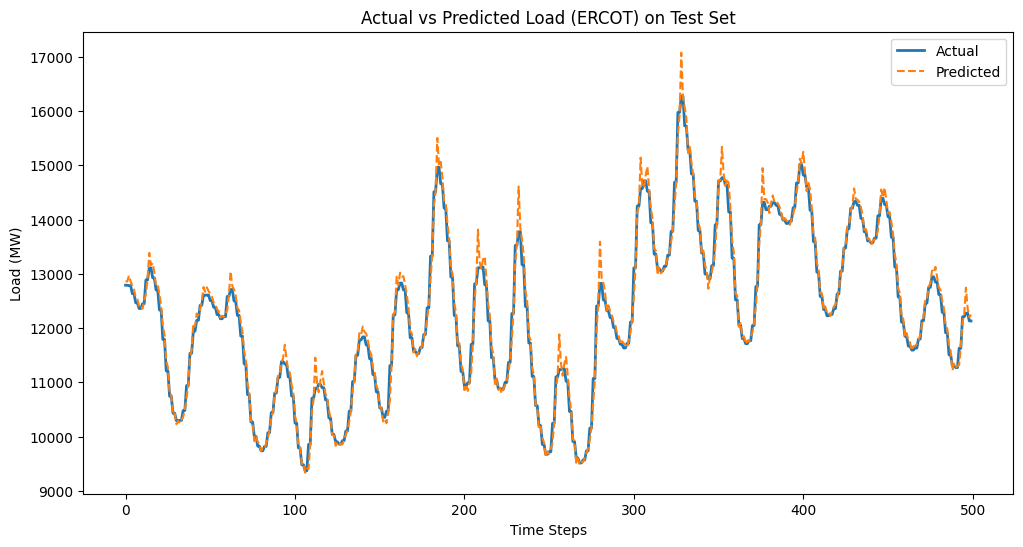

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual[:500], label='Actual', linewidth=2)
plt.plot(predictions[:500], label='Predicted', linestyle='dashed')
plt.title('Actual vs Predicted Load (ERCOT) on Test Set')
plt.xlabel('Time Steps')
plt.ylabel('Load (MW)')
plt.legend()
plt.show()


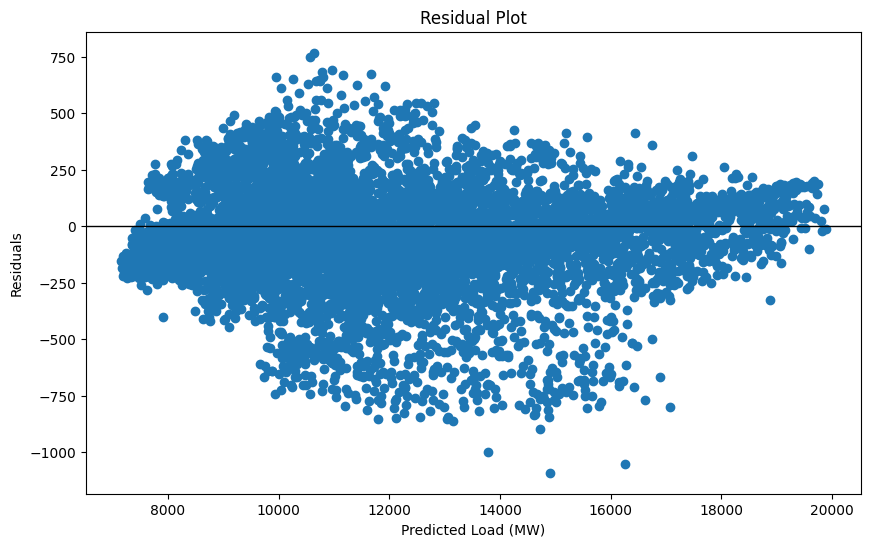

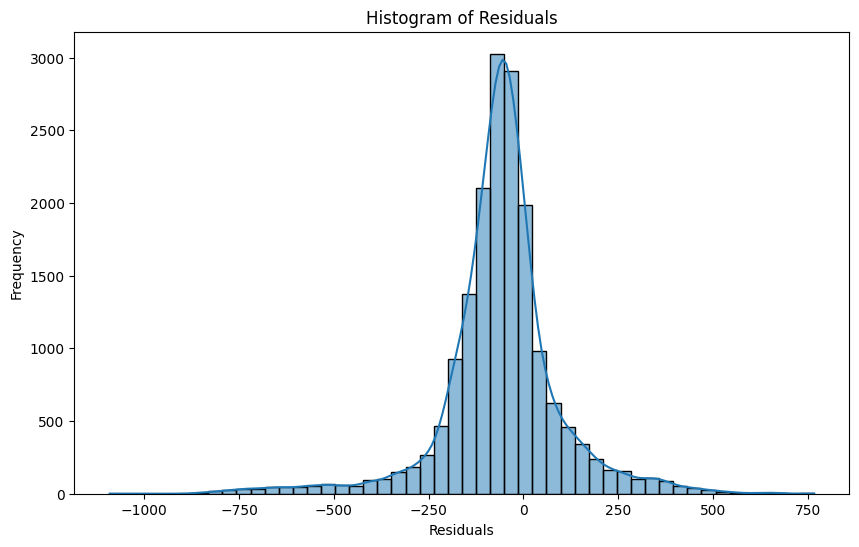

In [31]:
residuals = y_test_actual - predictions

# Residual Plot
plt.figure(figsize=(10, 6))
plt.scatter(predictions, residuals)
plt.axhline(0, color='black', lw=1)
plt.title('Residual Plot')
plt.xlabel('Predicted Load (MW)')
plt.ylabel('Residuals')
plt.show()

# Histogram of Residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=50)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


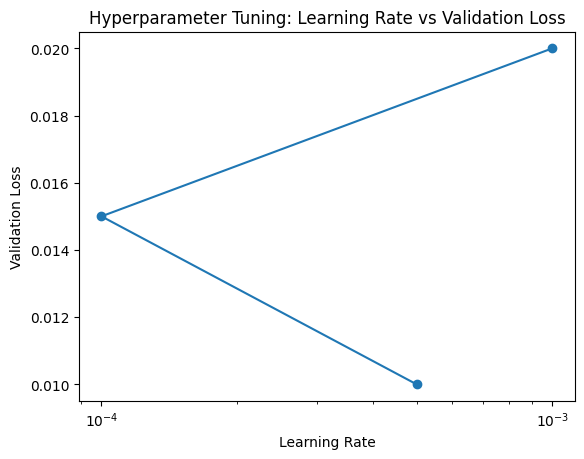

In [32]:
# Assuming you've stored the results of hyperparameter tuning in a list/dictionary
learning_rates = [1e-3, 1e-4, 5e-4]  # Example list
val_losses = [0.02, 0.015, 0.01]     # Corresponding validation losses

plt.plot(learning_rates, val_losses, marker='o')
plt.title('Hyperparameter Tuning: Learning Rate vs Validation Loss')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Loss')
plt.xscale('log')  # Log scale for better visualization
plt.show()


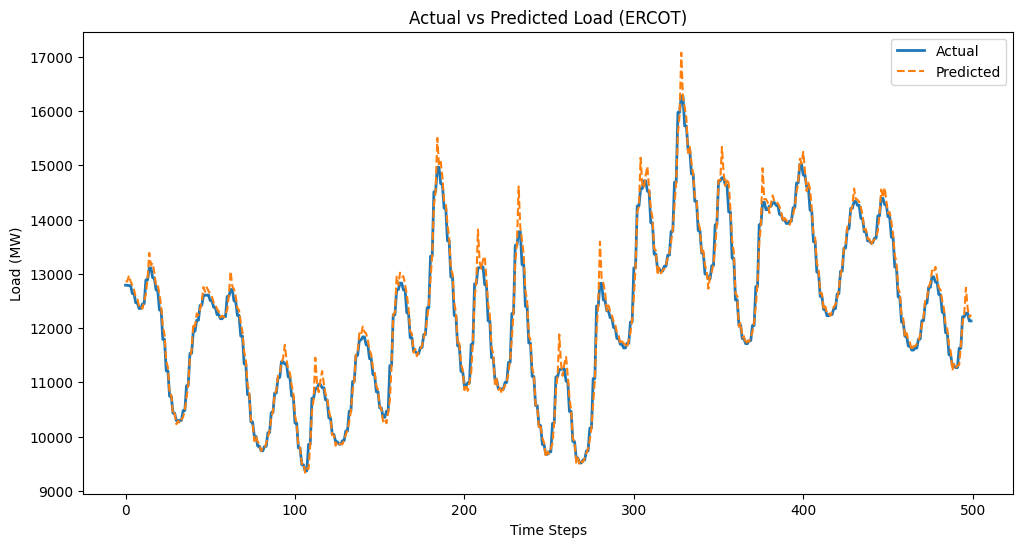

In [33]:
# Actual vs predicted plot

# Actual vs Predicted Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual[:500], label='Actual', linewidth=2)
plt.plot(predictions[:500], label='Predicted', linestyle='dashed')
plt.legend()
plt.title('Actual vs Predicted Load (ERCOT)')
plt.xlabel('Time Steps')
plt.ylabel('Load (MW)')
plt.show()


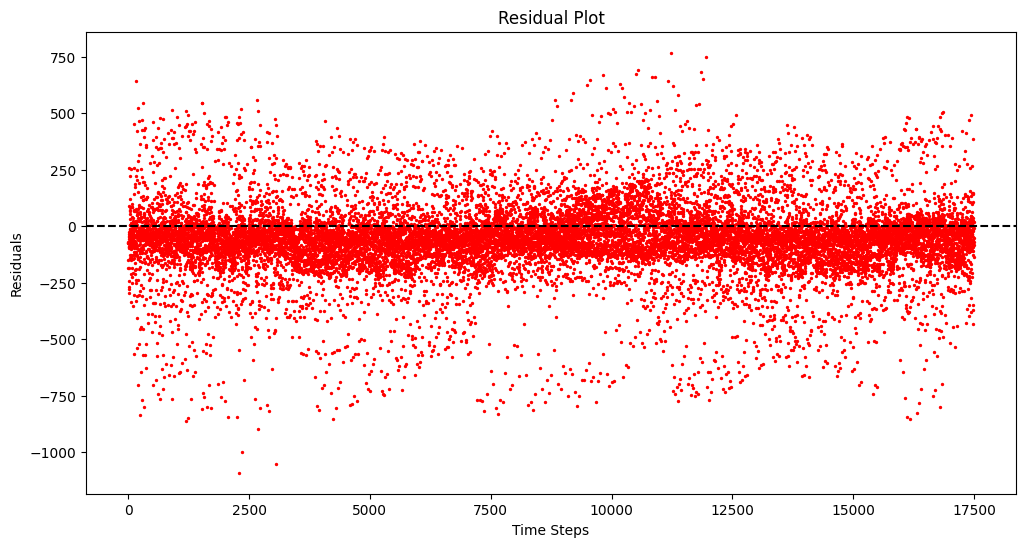

In [34]:
# Residual Plot
# Residual Plot
residuals = y_test_actual - predictions
plt.figure(figsize=(12, 6))
plt.scatter(range(len(residuals)), residuals, color='r', s=2)
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Time Steps')
plt.ylabel('Residuals')
plt.show()


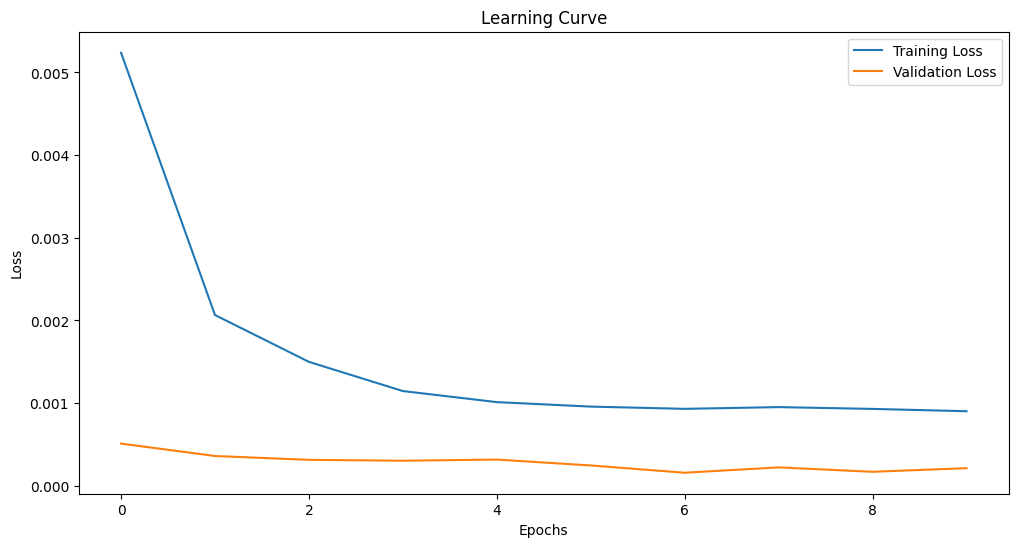

In [35]:
# Learning Curve
# Learning Curve: Plot training and validation loss over epochs
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


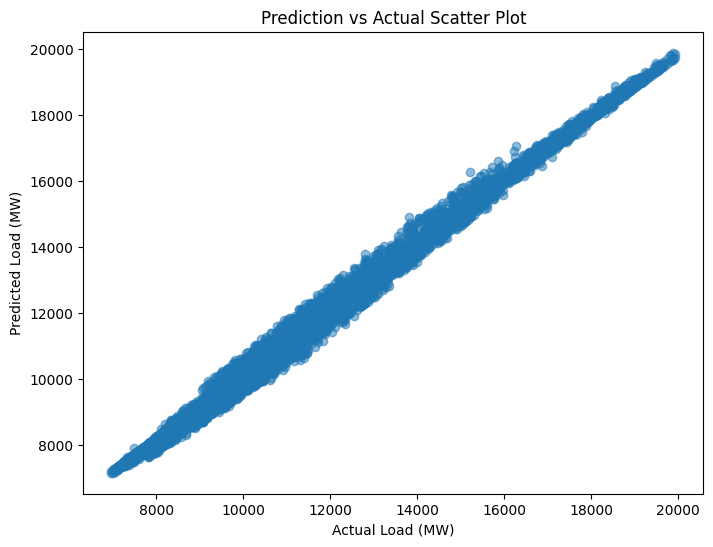

In [36]:
# Prediction vs Actual Scatter Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test_actual, predictions, alpha=0.5)
plt.title('Prediction vs Actual Scatter Plot')
plt.xlabel('Actual Load (MW)')
plt.ylabel('Predicted Load (MW)')
plt.show()


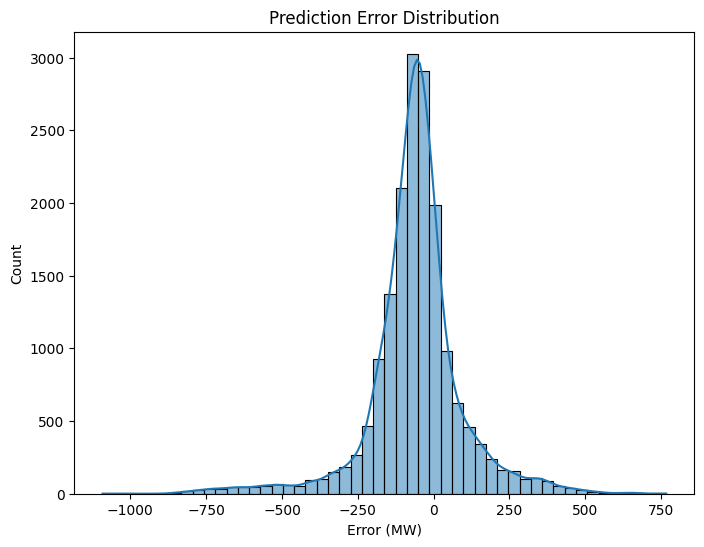

In [37]:
# Error Distribution Plot (Histogram)
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=50, kde=True)
plt.title('Prediction Error Distribution')
plt.xlabel('Error (MW)')
plt.ylabel('Count')
plt.show()


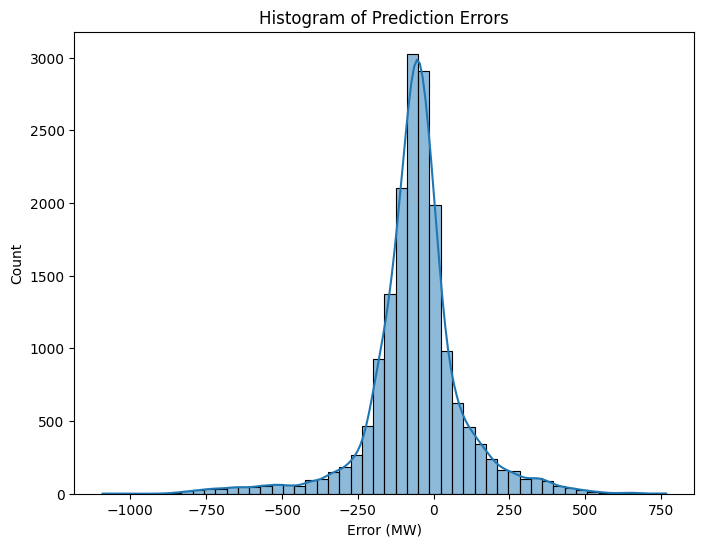

In [40]:
# Histogram of Prediction Errors (Residuals)
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=50, kde=True)
plt.title('Histogram of Prediction Errors')
plt.xlabel('Error (MW)')
plt.ylabel('Count')
plt.show()


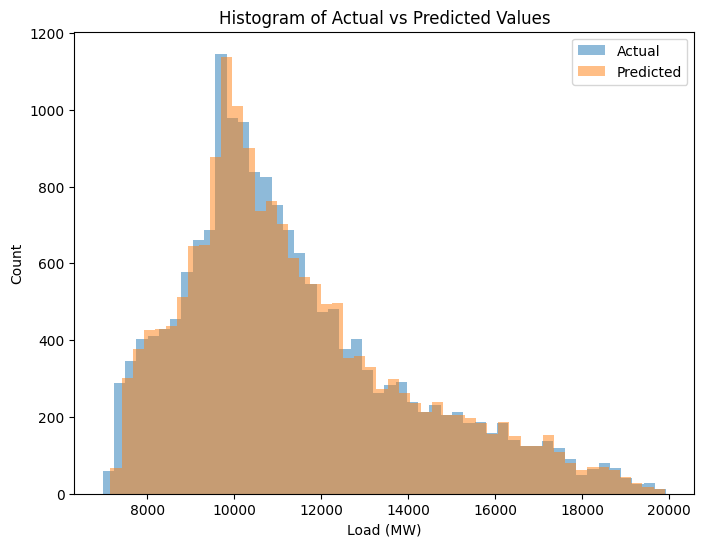

In [41]:
# Histogram of Actual vs Predicted Values
plt.figure(figsize=(8, 6))
plt.hist(y_test_actual, bins=50, alpha=0.5, label='Actual')
plt.hist(predictions, bins=50, alpha=0.5, label='Predicted')
plt.title('Histogram of Actual vs Predicted Values')
plt.xlabel('Load (MW)')
plt.ylabel('Count')
plt.legend()
plt.show()


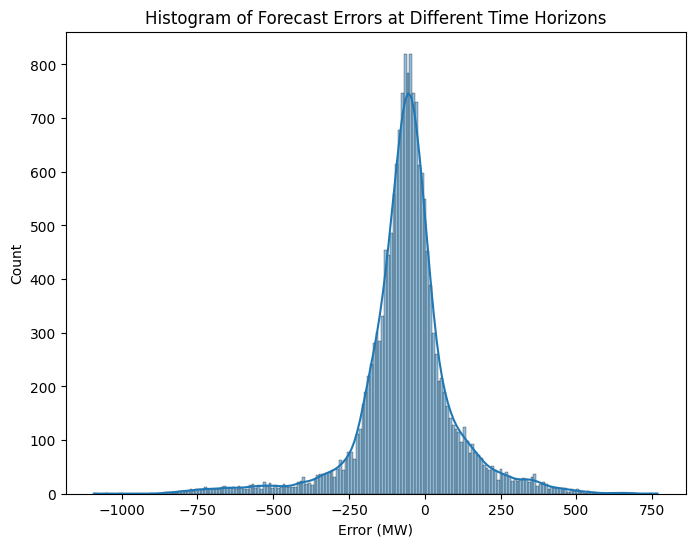

In [49]:
# Assuming time horizon is set (e.g., every hour, day, etc.)
forecast_errors_by_horizon = residuals  # Adjust to specific time horizons
plt.figure(figsize=(8, 6))
sns.histplot(forecast_errors_by_horizon, kde=True)
plt.title('Histogram of Forecast Errors at Different Time Horizons')
plt.xlabel('Error (MW)')
plt.ylabel('Count')
plt.show()
